# Numerical Methods Example

## Problem Outline

A classic example, known as the 1D advection equation.
Advection is the transport of some chemical (or any quantity really) by a fluid with a given velocity.

Our goal is to determine the concentration distribution over time.

We introduce the following variables:
- $t:$ time.
- $x:$ this represents a position in space, e.g. in a column or pipe.
In theory, we could consider more coordinates, but this adds complexity.
- $c:$ this is the concentration of the chemical being 'carried' by the fluid.
The concentration varies with space, $x$, and over time, $t$.
In general, this could be any quantity, e.g. mass.
- $\nu:$ the velocity of the fluid.
Can vary with time, $t$, and space, $x$.

We will consider a pipe with a fixed length, $L$.

To simplify the problem we make the following assumptions:

- The velocity of the fluid is constant (i.e. it doesn't change over time, $t$, and is the same at all positions, $x$).
- Diffusion of the chemical in the fluid is negligible.
- Concentration is small enough to not affect the motion of the fluid.

Based on the above we can derive the following hyperbolic partial differential equation (PDE):

$$
\frac{\partial c(x, t)}{\partial t} + \nu\frac{\partial c}{\partial x}=0
$$


### Initial and boundary conditions

The equation above only tells us how concentration evolves with time and space.
To solve it, we need the following:
- what the concentration is at the **start** (initial condition).
- what the concentration at the **boundaries** of the space we are considering (boundary condition/s).

We'll make the following assumptions
- The pipe is devoid of chemical at the start, i.e. $c(x,t=0)=c_0=0$.
This is our initial condition.
- The pipe is open-ended, so the fluid will keep flowing out of the pipe.
This is our first boundary condition.
- The feed rate to the pipe is slowly increased up to a point, then fed at a constant rate. i.e. $$\frac{\mathrm{d}c_\mathrm{in}}{\mathrm{d} t} =
\begin{cases}
    2, & \text{if} & t < 5 \\
    0, & \text{if} & t \geq 5
\end{cases}$$
This is our second boundary condition.

## Solution Algorithm


Before writing any code, we should think about how we are going to solve the problem.
More often than not, this will save us time in the long run.
A graphical way to do this is using a flowchart of the algorithm we will implement.
Our algorithm is just an overview of the high-level instructions we will give the computer.
<div style="text-align: center; background-color: white; display: inline-block;">
    <img src="images/flowchart_TA_example.svg" alt="Advection semi-discrete ODE algorithm">
</div>

## Numerical Solution
Before starting, we must import the libraries we are going to be using:
- NumPy: you'll see this in a lot of scientific programs. NumPy arrays work very similarly to MATLAB  matrices.
- Scipy: a popular library that has ODE solvers for us to use out-of-the-box.
- Matplotlib: this will allow us to visualise our data using plots and animations. It's designed to be very similar to matlab.

In [1]:
# required
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# optional
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### 1. Problem statement
First, we store the inputs from the problem statement as variables.

In [2]:
# inputs:
# initial condition
initial_concentration = 0.0  # this represents the concentration everywhere, c(x, t=0)

# operating conditions
velocity = 2.0  # [m/min] - could be any units, as long as we are consistent!
feed_concentration_rate = 2.0  # [mol/m3/min] - part of our boundary condition
steady_state_time = 5.0  # [min] - part of our boundary condition

# Grid definition
pipe_start = 0.0  # [m] - this is just a reference, could be any value
pipe_end = 30  # [m]

# time span
time_span = (0, 40)  # [min]

### 2. Model discretization

#### 2.1. Initial condition discretization
To start, we must discretize the initial condition.
This is important since it controls what the solution is going to look like.

In [3]:
# discretize the domain - divide the pipe into discrete lengths
grid_spacing = 0.05  # [m] - the distance between the finite difference points
length_array = np.arange(pipe_start, pipe_end + grid_spacing, grid_spacing)
# ! what will happen if we increase the grid spacing?

# discretize the initial distribution of concentration in the pipe
initial_concentration_distribution = np.full_like(length_array, initial_concentration)

#### 2.2. ODE discretization
Next we discretize our ODE system.
SciPy has a particular format it wants the ODE system to be defined in that we must follow.

##### 2.2.1. For loop ODE system
Our first attempt at defining our ODE system might look something like this

In [ ]:
def ode_system(
    t,
    y,
    velocity: float,
    length_array: np.ndarray,
    feed_concentration_rate: float,
    steady_state_time: float,
    grid_spacing: float,
):
    # unpack the state
    concentration_distribution = y

    # determine the number of points in the pipe
    number_of_points = length_array.size

    # initialize an array to store derivatives
    dydt = np.zeros(number_of_points)

    # determine the feed concentration
    if t < steady_state_time:
        feed_concentration = feed_concentration_rate * t
    else:
        feed_concentration = feed_concentration_rate * steady_state_time

    # determine the derivative at the boundary
    dydt[0] = (
        velocity * (feed_concentration - concentration_distribution[0]) / grid_spacing
    )
    # we could have used a ghost cell instead for the boundary, and avoided handling it separately - see vectorized version below

    # determine the derivatives for the interior points
    for i in range(1, number_of_points):
        dydt[i] = (
            velocity
            * (concentration_distribution[i - 1] - concentration_distribution[i])
            / grid_spacing
        )

    return dydt

The problem with the above method is that Python for loops are incredibly slow.

Fortunately, NumPy helps us speed up our code by providing vectorization.

##### 2.2.2. Vectorized ODE system (efficient)

'Vectorizing' is what numpy is designed for. Instead of performing calculations on each element of an array one by one using a for loop, we can calculate all at once using efficient *vectorized* algorithms.

Here is what our ODE system might look like when vectorized

In [ ]:
def ode_system_fast(
    t,
    y,
    velocity: float,
    lengthArray: np.ndarray,
    feed_concentration_rate: float,
    steady_state_time: float,
    grid_spacing: float,
):
    if t < steady_state_time:
        feed_concentration = feed_concentration_rate * t
    else:
        feed_concentration = feed_concentration_rate * steady_state_time

    # add ghost cells (boundary conditions) to current state
    concentration_distribution = np.insert(y, 0, feed_concentration)

    # determine number of points in the pipe
    number_of_points = lengthArray.size

    # initialize an array to store derivatives
    dydt = np.zeros(number_of_points)

    # generate the derivatives using finite difference
    dydt = (
        velocity
        * (concentration_distribution[:-1] - concentration_distribution[1:])
        / grid_spacing
    )

    return dydt

Vectorization is great for speeding up numpy code, but it can get a little confusing!
This is why understanding for loops is recommended to start with, before moving on to vectorization.

### 3. Solution and Visualisation

#### 3.1. Solution
We should now have everything in place to use the SciPy solver.

In [ ]:
# solve the ode system
solution = solve_ivp(
    ode_system_fast,
    time_span,
    initial_concentration_distribution,
    args=(
        velocity,
        length_array,
        feed_concentration_rate,
        steady_state_time,
        grid_spacing,
    ),
    method="LSODA",
    t_eval=np.linspace(time_span[0], time_span[1], 100),  # optional - better animation
)

# extract solution
times_array = solution.t
concentration_distributions = solution.y

#### 3.2. Visualisation
The computer has a solution to our problem, but its just an array of numbers. We will use our plotting library to make sense of the numbers through visualising.

##### 3.2.1. Saturation time (concentration at pipe end)
This is the time taken for the pipe to have the same concentration as the feed throughout the whole pipe (i.e., steady state).
We can determine this by focusing on the end of the pipe ($x=L$).

We can determine this using our numerical solution of course, but we can also derive the analytical solution easily:
1. First, we can determine how long until the end of the pipe begins to saturate using:
$$
t_\mathrm{sat, start}=\frac{L}{\nu}
$$
2. Then, we know that the concentration will increase linearly for the duration taken for the feed to be steady, which has been given in the problem statement ($\Delta t_\mathrm{sat}$).
3. Finally, we know that that the concentration will be constant at a value of $2 \Delta t_\mathrm{sat}$ after that (from the boundary condition). We can calculate the time taken for saturation to be achieved using:
$$
t_\mathrm{sat, end} = t_\mathrm{sat, start} + \Delta t_\mathrm{sat}
$$

In [ ]:
# analytical solution
# we can use this to generate a concentration profile for the pipe end
# same timespan used as the numerical solution
saturation_start_time = (pipe_end - pipe_start) / velocity
analytical_times = np.concatenate(
    [
        [0],
        np.linspace(
            saturation_start_time, saturation_start_time + steady_state_time
        ),  # step change
        [time_span[1]],
    ]
)
analytical_concentrations = np.concatenate(
    [
        [initial_concentration],  # initial
        np.linspace(initial_concentration, feed_concentration_rate * steady_state_time),
        [feed_concentration_rate * steady_state_time],  # final
    ]
)

We can visualise the saturation time by plotting the concentration at the end of the pipe against the time.
We'll do this for both solutions, numerical and analytical, to compare

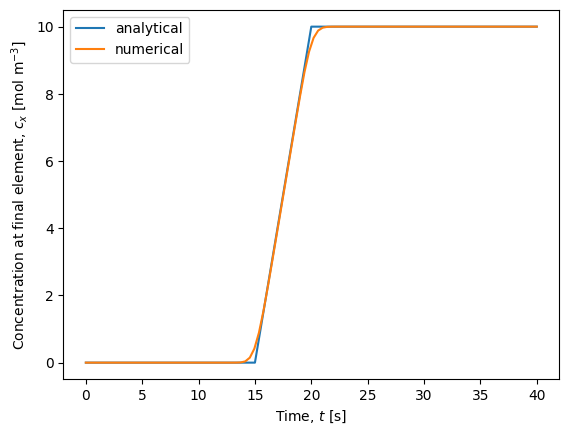

In [ ]:
%matplotlib inline

# set up the figure
plt.figure()
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Concentration at final element, $c_x$ [mol m$^{-3}$]")

# plot solutions
plt.plot(analytical_times, analytical_concentrations, label="analytical")
plt.plot(times_array, concentration_distributions[-1, :], label="numerical")

plt.legend()

plt.show()

We notice that the numerical solution is smooth, even though the analytical one is sharp.

##### 3.2.2. Concentration Distribution Evolution (Animation)
We can animate the evolution of the concentration distribution (over the whole pipe) over time.
This will give us a complete picture over what is happening in the pipe over time.

*Note that the animation will only work when run in a Jupyter environment (browser, Google colab, or vscode).*

In [9]:
# set up the figure and axes with initial frame
figure, axes = plt.subplots()
(line,) = axes.plot(length_array, concentration_distributions[:, 0], color="b")
axes.set_xlim(pipe_start, pipe_end)
axes.set_ylim(
    np.min(concentration_distributions), 1.1 * np.max(concentration_distributions)
)
axes.set_xlabel("pipe Length, $x$ [m]")
axes.set_ylabel("Concentration [mol m$^{-3}$]")
axes.set_title(r"Concentration Distribution in pipe at t=0")


# initialization function: plot the background of each frame
def init():
    line.set_ydata(np.ma.array(length_array, mask=True))
    return (line,)


# update function: this is called for each frame to update the plot
def update(frame):
    line.set_ydata(concentration_distributions[:, frame])
    axes.set_title(f"Concentration Distribution in pipe at t={times_array[frame]:.2f}s")
    return (line,)


# create the animation
animation = FuncAnimation(
    figure, update, frames=len(times_array), init_func=init, blit=True, repeat=False
)

# save the animation
animation.save("images/distributionOverTime.mp4")

# suppress weird output
plt.close(figure)

# display animation
HTML(animation.to_html5_video())